
Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 57s 363ms/step - accuracy: 0.4001 - loss: 9.2847 - val_accuracy: 0.4917 - val_loss: 8.2549 - learning_rate: 5.0000e-05
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 359ms/step - accuracy: 0.5103 - loss: 7.9337 - val_accuracy: 0.4917 - val_loss: 7.1431 - learning_rate: 5.0000e-05
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 359ms/step - accuracy: 0.5103 - loss: 6.8142 - val_accuracy: 0.4917 - val_loss: 6.1711 - learning_rate: 5.0000e-05
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 354ms/step - accuracy: 0.5103 - loss: 5.8569 - val_accuracy: 0.4917 - val_loss: 5.3710 - learning_rate: 5.0000e-05
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 354ms/step - accuracy: 0.5103 - loss: 5.0781 - val_accuracy: 0.4917 - val_loss: 4.7686 - learning_rate: 5.0000e-05
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 359ms/step - accuracy: 0.5103 - loss: 4.5035 - val_accuracy: 0.4917 - val_loss: 4.3620 - learning_rate: 5.0000e-05
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 49s 3

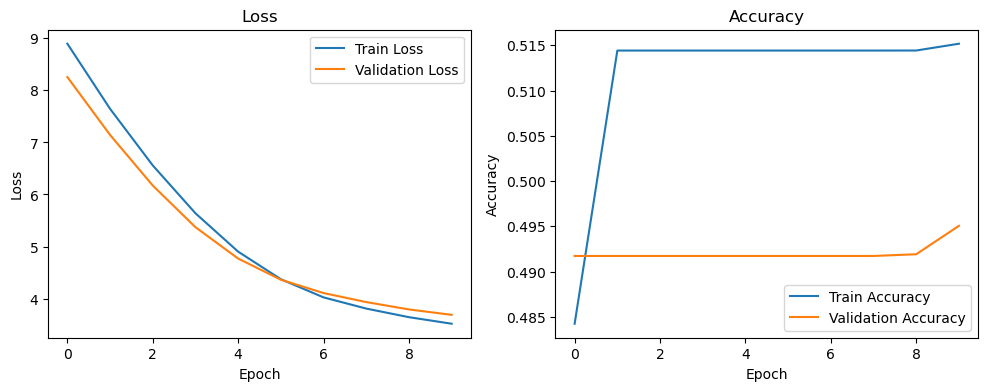

In [1]:
import os
import pandas as pd
import numpy as np
import random
import string
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Model parameters
batch_size = 128  # Increased batch size
embed_dim = 128
num_heads = 8  # Number of attention heads
latent_dim = 512  # Dimension of the feed-forward network
vocab_size = 20000
sequence_length = 20
dropout = 0.3  # Dropout rate to combat overfitting

# Function for text preprocessing
def preprocess_text(df):
    # Lowercase and remove URLs, digits, and special characters
    df["English"] = df["English"].apply(lambda x: re.sub(r"http\S+|\d+", "", x.lower()))
    df["Hindi"] = df["Hindi"].apply(lambda x: re.sub(r"http\S+|\d+|[a-zA-Z]", "", x.lower()))
    special = set(string.punctuation)
    df['English'] = df['English'].apply(lambda x: ''.join(ch for ch in x if ch not in special))
    df['Hindi'] = df['Hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in special))
    df['English'] = df['English'].str.strip().str.replace(" +", " ", regex=True)
    df['Hindi'] = df['Hindi'].str.strip().str.replace(" +", " ", regex=True)
    df["Hindi"] = df["Hindi"].apply(lambda x: "[start] " + x + " [end]")

# Load and preprocess dataset
df = pd.read_csv("Dataset_English_Hindi.csv", names=["English", "Hindi"]).dropna().iloc[:30000]
preprocess_text(df)
df["eng_len"] = df["English"].str.split().apply(len)
df["hin_len"] = df["Hindi"].str.split().apply(len)
df = df[(df["eng_len"] <= 20) & (df["hin_len"] <= 20)]

# Split dataset into train, validation, and test sets
total_samples = len(df)
train_size = int(0.8 * total_samples)  # 80% for training
val_size = int(0.1 * total_samples)  # 10% for validation
test_size = total_samples - train_size - val_size  # Remaining 10% for testing

train = df.iloc[:train_size]
val = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]

# Text vectorization
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "").replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

eng_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length)
hindi_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length + 1, standardize=custom_standardization)

eng_vectorization.adapt(df["English"].values)
hindi_vectorization.adapt(df["Hindi"].values)

def format_dataset(eng, hin):
    eng = eng_vectorization(eng)
    hindi = hindi_vectorization(hin)
    return {"encoder_inputs": eng, "decoder_inputs": hindi[:, :-1]}, hindi[:, 1:]

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["English"].values, df["Hindi"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(tf.data.AUTOTUNE).cache()  # Ensure caching is used

train_ds = make_dataset(train)
val_ds = make_dataset(val)
test_ds = make_dataset(test)

# Positional Embedding, Transformer Encoder, and Transformer Decoder classes
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_len, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = layers.Embedding(input_dim=sequence_len, output_dim=embed_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
        return self.token_embedding(inputs) + self.position_embedding(positions)

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, dropout, **kwargs):
        super().__init__(**kwargs)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.layer_ffn = keras.Sequential([layers.Dense(latent_dim, activation="relu"),
                                           layers.Dropout(dropout),
                                           layers.Dense(embed_dim)])

    def call(self, inputs, mask=None):
        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=mask)
        ffn_input = self.layer_norm1(inputs + attention_output)
        return self.layer_norm2(ffn_input + self.layer_ffn(ffn_input))

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, dropout, **kwargs):
        super().__init__(**kwargs)
        self.attention1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.layer_norm3 = layers.LayerNormalization()
        self.layer_ffn = keras.Sequential([layers.Dense(latent_dim, activation="relu"),
                                           layers.Dropout(dropout),
                                           layers.Dense(embed_dim)])

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, seq_len = input_shape[0], input_shape[1]
        i = tf.range(seq_len)[:, None]
        j = tf.range(seq_len)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, seq_len, seq_len))
        return tf.tile(mask, [batch_size, 1, 1])

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        attention_output1 = self.attention1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        out1 = self.layer_norm1(inputs + attention_output1)
        attention_output2 = self.attention2(query=out1, value=encoder_outputs, key=encoder_outputs, attention_mask=mask)
        out2 = self.layer_norm2(out1 + attention_output2)
        return self.layer_norm3(out2 + self.layer_ffn(out2))

# Transformer Model
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads, dropout)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads, dropout)(x, encoder_outputs)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-5),  # Adjusted learning rate
                    loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Training with callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = transformer.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping, reduce_lr], verbose=1)  # Increased epochs


# Evaluate the model on the test set
test_loss, test_accuracy = transformer.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


# Plotting training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [4]:
def decode_sequence(input_sentence):
    # Retrieve Hindi vocabulary and create an index lookup
    hindi_vocab = hindi_vectorization.get_vocabulary()
    hindi_index_lookup = dict(zip(range(len(hindi_vocab)), hindi_vocab))

    max_decoded_sentence_length = 20  # Maximum length of the decoded sentence
    tokenized_input_sentence = eng_vectorization([input_sentence])  # Tokenize the input sentence
    decoded_sentence = "[start]"  # Initialize the decoded sentence with the start token

    # Decoding loop
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = hindi_vectorization([decoded_sentence])[:, :-1]  # Exclude last token
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])[:, -1, :]  # Predict next token
        sampled_token_index = tf.random.categorical(predictions, num_samples=1).numpy()[0][0]  # Sample from predictions
        sampled_token = hindi_index_lookup[sampled_token_index]  # Get the actual Hindi word

        if sampled_token == "[end]":  # Stop if end token is predicted
            break
        decoded_sentence += " " + sampled_token  # Append the predicted token to the decoded sentence

    return decoded_sentence.strip()  # Return the decoded sentence without leading/trailing whitespace

# Example translation
eng_sentence = "how are you"  # English sentence to be translated
print("English Sentence:", eng_sentence)
print("Translated Sentence:", decode_sequence(eng_sentence))  # Print the translated sentence


English Sentence: how are you
Translated Sentence: [start] उद्योगीकरण यादृच्छिक गणक इस्तेमाल लायक तीस टेलर वेतन स्ट्रिप छेद मेनन लगाऊँगा नदियां खिलाफ चुकी उपेक्षित कालक्रम निकलते श्रेणीसंचिका अभी
